In [ ]:
import warnings

from datetime import datetime

import numpy as np
import pandas as pd
import pandas_datareader.data as web

import seaborn as sns

import statsmodels.api as sm
from matplotlib import pyplot
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_val_score,
    train_test_split,
)

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import PolynomialFeatures

warnings.filterwarnings("ignore")

In [ ]:
# downloading the data
start = datetime(2007, 6, 30)
end = datetime(2022, 6, 30)

data = [
    "DGS1MO",
    "DGS3MO",
    "DGS1",
    "DGS2",
    "DGS5",
    "DGS7",
    "DGS10",
    "DGS30",
    "TREAST",  # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
    "FYGFDPUN",  # -- Federal Debt Held by the Public ( Millions of Dollars )
    "FDHBFIN",  # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
    "GFDEBTN",  # -- Federal Debt: Total Public Debt ( Millions of Dollars )
    "BAA10Y",  # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
]
data = web.DataReader(data, "fred", start, end).dropna(how="all").ffill()
data["FDHBFIN"] = data["FDHBFIN"] * 1000
data["GOV_PCT"] = data["TREAST"] / data["GFDEBTN"]
data["HOM_PCT"] = data["FYGFDPUN"] / data["GFDEBTN"]
data["FOR_PCT"] = data["FDHBFIN"] / data["GFDEBTN"]

In [ ]:
data.rename(
    columns={
        "DGS1MO": "1m",
        "DGS3MO": "3m",
        "DGS1": "1y",
        "DGS2": "2y",
        "DGS5": "5y",
        "DGS7": "7y",
        "DGS10": "10y",
        "DGS30": "30y",
    },
    inplace=True,
)
return_period = 5

Y = data.loc[:, ["1m", "5y", "30y"]].shift(-return_period)
Y.columns = [col + "_pred" for col in Y.columns]

X = data.loc[
    :,
    [
        "1m",
        "3m",
        "1y",
        "2y",
        "5y",
        "7y",
        "10y",
        "30y",
        "GOV_PCT",
        "HOM_PCT",
        "FOR_PCT",
        "BAA10Y",
    ],
]

df = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = df.loc[:, Y.columns]
X = df.loc[:, X.columns]

df.head(10)

,1m_pred,5y_pred,30y_pred,1m,3m,1y,2y,5y,7y,10y,30y,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2007-07-04,4.73,4.98,5.18,4.77,4.95,4.98,4.89,4.95,4.99,5.05,5.14,0.087765,0.56055,0.248156,1.60
2007-07-11,4.77,4.91,5.10,4.73,4.95,4.99,4.89,4.98,5.02,5.09,5.18,0.087770,0.56055,0.248156,1.59
2007-07-18,5.04,4.80,5.04,4.77,4.96,4.98,4.84,4.91,4.95,5.02,5.10,0.087776,0.56055,0.248156,1.58
2007-07-25,5.05,4.60,4.90,5.04,4.99,4.95,4.74,4.80,4.85,4.92,5.04,0.087782,0.56055,0.248156,1.65
2007-08-01,5.04,4.69,5.01,5.05,4.89,4.82,4.56,4.60,4.66,4.76,4.90,0.087792,0.56055,0.248156,1.86
2007-08-08,4.18,4.41,5.00,5.04,4.95,4.89,4.64,4.69,4.75,4.84,5.01,0.087794,0.56055,0.248156,1.87
2007-08-15,3.12,4.34,4.96,4.18,4.21,4.41,4.27,4.41,4.52,4.69,5.00,0.087659,0.56055,0.248156,2.03
2007-08-22,4.02,4.31,4.88,3.12,3.67,4.10,4.15,4.34,4.46,4.63,4.96,0.087661,0.56055,0.248156,2.07
2007-08-29,4.28,4.20,4.79,4.02,3.98,4.24,4.14,4.31,4.41,4.57,4.88,0.087108,0.56055,0.248156,2.05


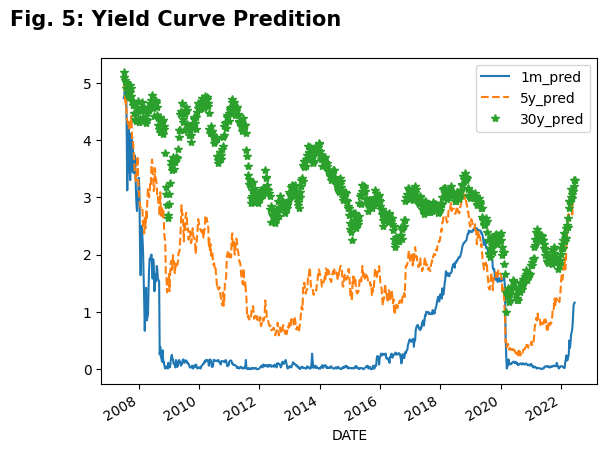

In [ ]:
Y.plot(style = ['-', '--', '*'])
pyplot.suptitle(
    'Fig. 5: Yield Curve Predition',
    fontweight = 'bold',
    horizontalalignment = 'right',
    fontsize = 15,
)
pyplot.show()

<Figure size 1500x1500 with 0 Axes>

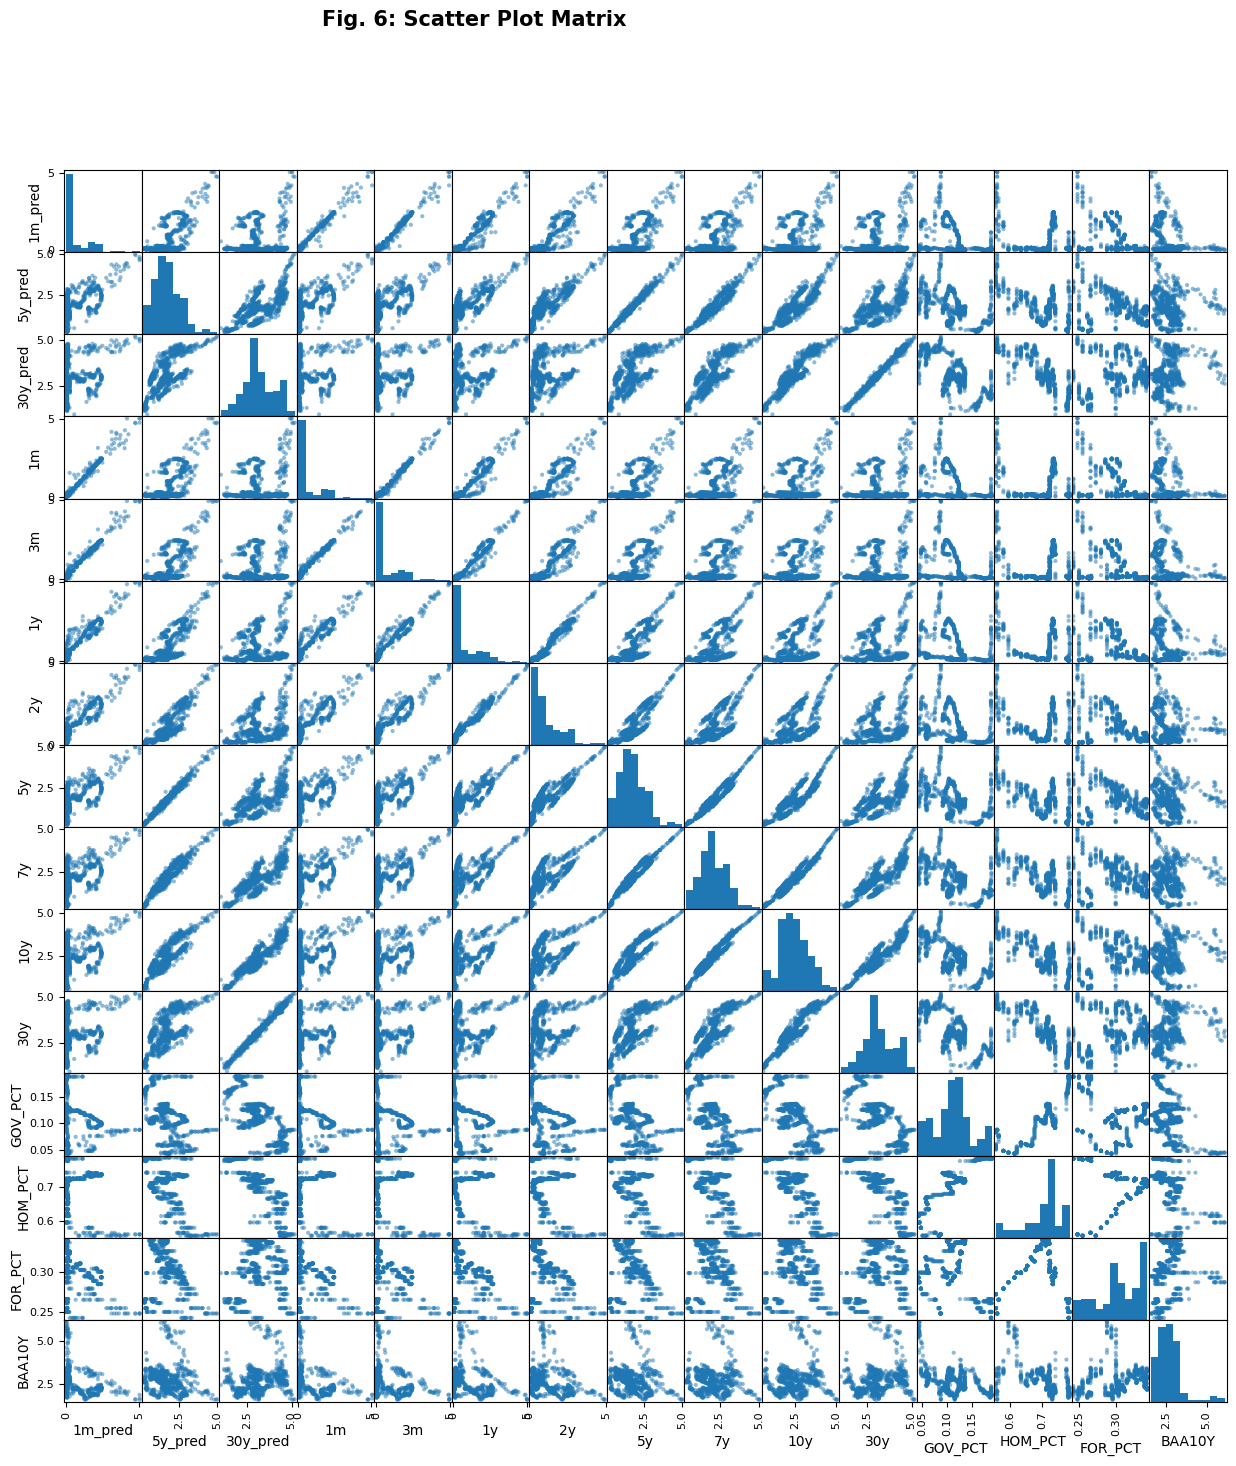

In [ ]:
pyplot.figure(figsize = (15, 15))
scatter_matrix(df, figsize = (15, 16))
pyplot.suptitle(
    'Fig. 6: Scatter Plot Matrix',
    fontweight = 'bold',
    horizontalalignment = 'right',
    fontsize = 15,
)
pyplot.show()

In [ ]:
df.columns

Index(['1m_pred', '5y_pred', '30y_pred', '1m', '3m', '1y', '2y', '5y', '7y',
       '10y', '30y', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y'],
      dtype='object')

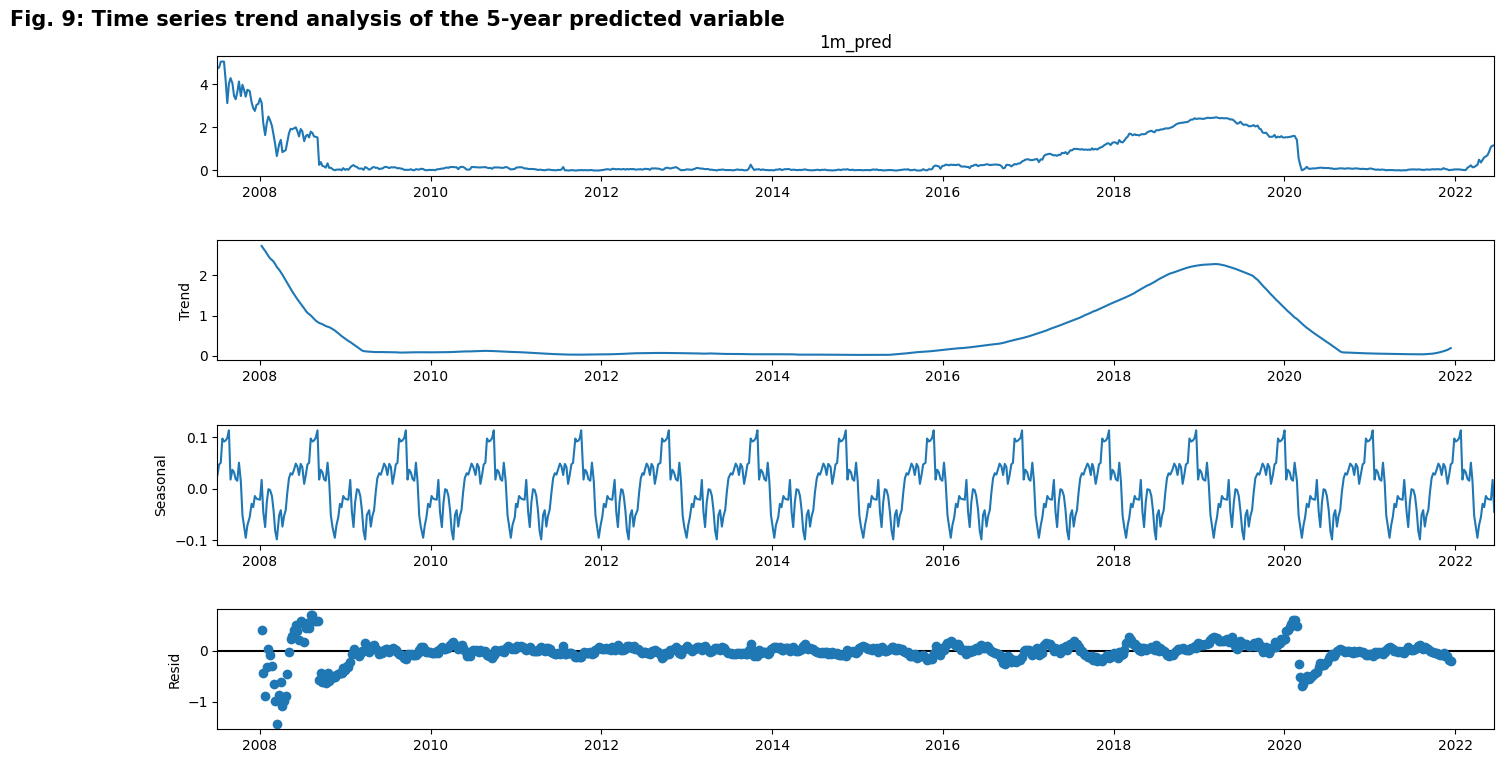

In [ ]:
temp_Y = df['1m_pred']
res = sm.tsa.seasonal_decompose(temp_Y, period = 52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.suptitle(
    'Fig. 9: Time series trend analysis of the 5-year predicted variable',
    fontweight = 'bold',
    horizontalalignment = 'right',
    fontsize = 15
)
pyplot.show()

In [ ]:
test_size = 0.2
seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state = seed
)

In [ ]:
num_folds = 10
scoring = 'neg_mean_squared_error'


In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)
MSE = mean_squared_error(y_test, pred)

print("Linear regression mean squared error : ", MSE)

Linear regression mean squared error :  0.01546723322935402


In [ ]:
poly = PolynomialFeatures(degree = 2)
X_train2 = poly.fit_transform(X_train)
X_test2 = poly.fit_transform(X_test)

model = lr.fit(X_train2, y_train)

print(
    'quadratic regression mean squared error : ',
    mean_squared_error(y_test, model.predict(X_test2)),
)

poly = PolynomialFeatures(degree = 3)
X_train3 = poly.fit_transform(X_train)
X_test3 = poly.fit_transform(X_test)

model = lr.fit(X_train3, y_train)

print(
    'degree 3 polynomial regression mean squared error : ',
    mean_squared_error(y_test, model.predict(X_test3))
)

quadratic regression mean squared error :  0.03929743040563507
degree 3 polynomial regression mean squared error :  3.1772129690232624


In [ ]:
num_folds = 10
scoring = 'neg_mean_squared_error'

In [ ]:
models = []

models.append(("LR", LinearRegression()))
models.append(("MLP", MLPRegressor()))

In [ ]:
from tables.tests.common import print_heavy
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits = num_folds)
    cv_results = -1 * cross_val_score(
        model, X_train, y_train, cv= kfold, scoring = scoring
    )
    kfold_results.append(cv_results)
    names.append(name)

    res = model.fit(X_train, y_train)
    validation_result = np.mean(np.square(res.predict(X_test)- y_test))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train)  - y_train ))

    train_results.append(train_result)

    msg = (
        '%s: \nAverage CV error : %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s'
        %(
            name,
            str(cv_results.mean()),
            str(cv_results.std()),
            str(train_result),
            str(validation_result),
        )
    )
    print(msg)
    print('........................')

LR: 
Average CV error : 0.013481909862415839 
Std CV Error: (0.0049650005718474026) 
Training Error:
1m_pred     0.011670
5y_pred     0.013356
30y_pred    0.012174
dtype: float64 
Test Error:
1m_pred     0.021988
5y_pred     0.012084
30y_pred    0.012330
dtype: float64
........................
MLP: 
Average CV error : 0.017774391531663034 
Std CV Error: (0.005194223722300367) 
Training Error:
1m_pred     0.014136
5y_pred     0.015650
30y_pred    0.018609
dtype: float64 
Test Error:
1m_pred     0.027400
5y_pred     0.013954
30y_pred    0.017801
dtype: float64
........................


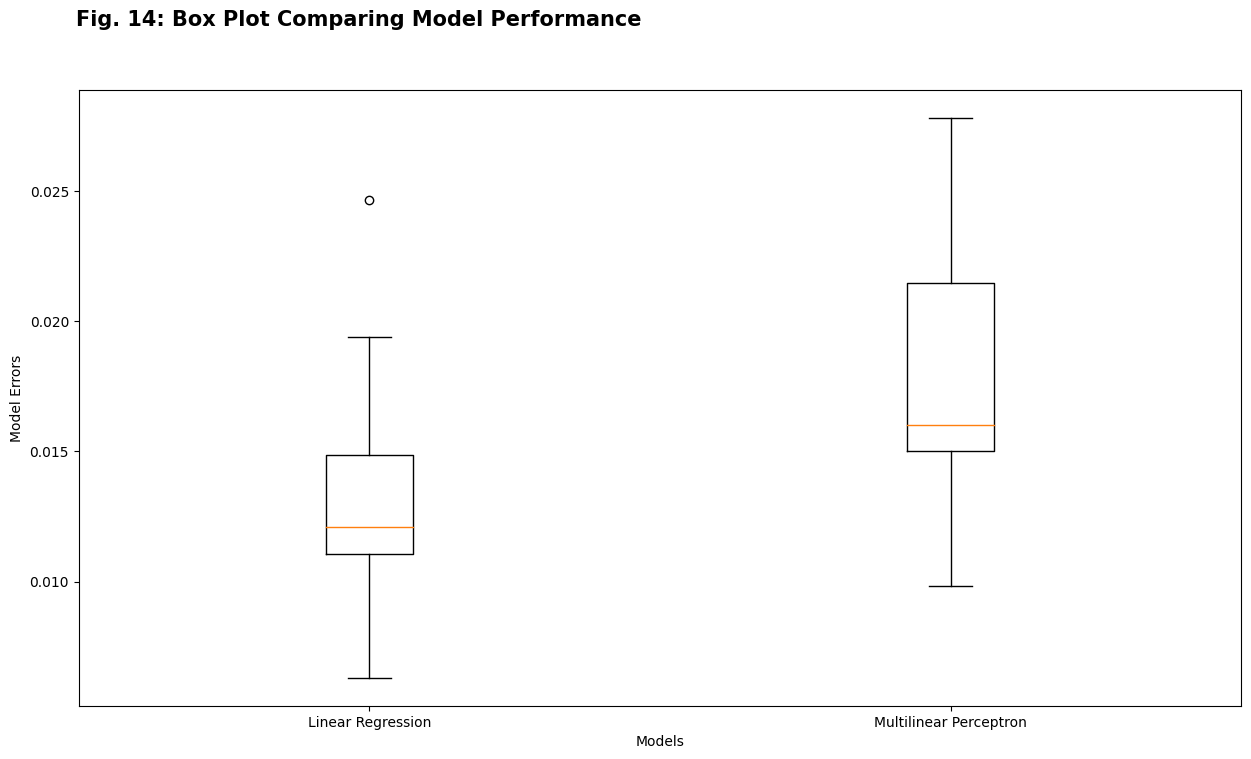

In [ ]:
# compare algorithms
names = ["Linear Regression", "Multilinear Perceptron"]
fig = pyplot.figure()
# print('\033[1m' + 'Fig 14: Box Plot Comparing Model Performance' + '\033[0m' )
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
pyplot.ylabel("Model Errors")
pyplot.xlabel("Models")
pyplot.suptitle(
    "Fig. 14: Box Plot Comparing Model Performance",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show()

In [ ]:
kfold_results

[array([0.02463412, 0.01320287, 0.0094148 , 0.01115134, 0.01245689,
        0.0063152 , 0.01177   , 0.01541506, 0.01940685, 0.01105196]),
 array([0.02780475, 0.01728363, 0.01350533, 0.01652235, 0.01537252,
        0.00983316, 0.01549995, 0.02285769, 0.02417623, 0.01488832])]

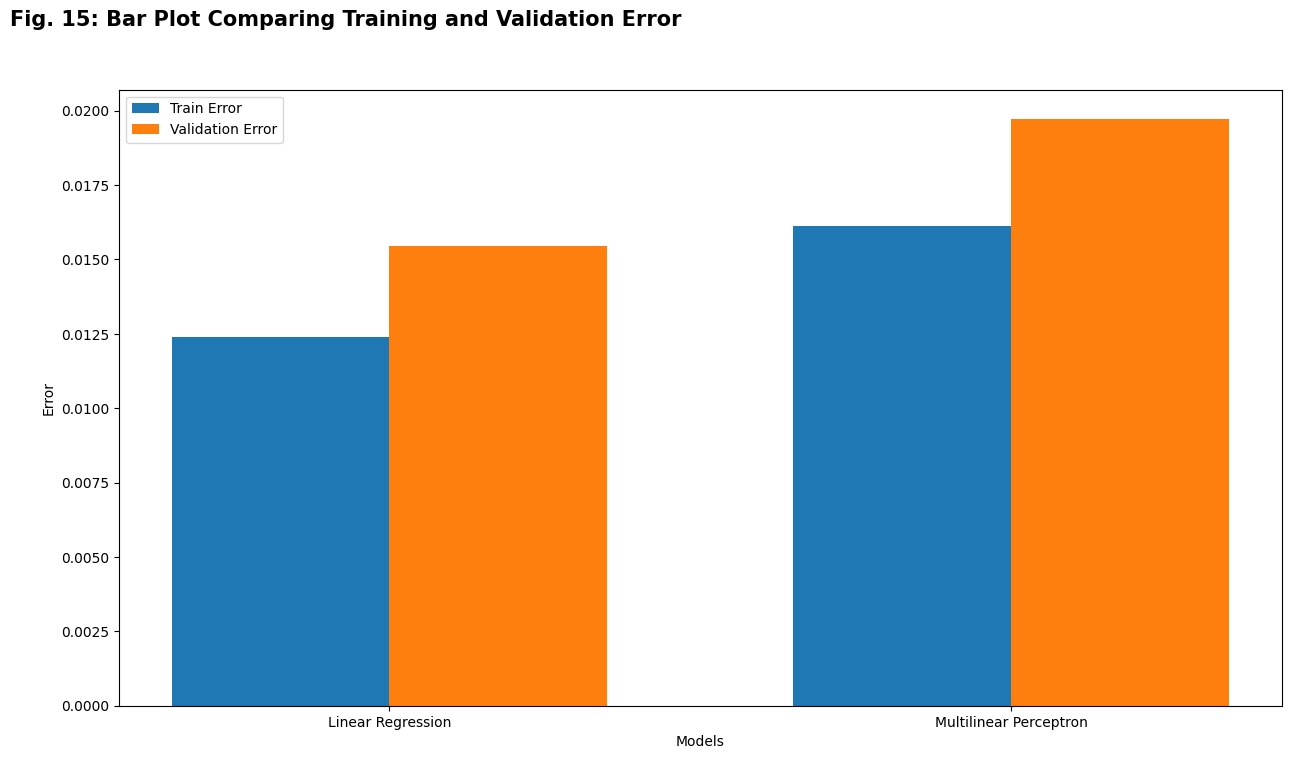

In [ ]:
fig = pyplot.figure()

ind = np.arange(len(names))
width = 0.35

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

pyplot.bar(
    ind - width / 2, [x.mean() for x in train_results], width  = width, label = 'Train Error',
)
pyplot.bar(
    ind + width/ 2,
    [x.mean() for x in validation_results], width = width ,
    label = 'Validation Error',
)

fig.set_size_inches(15, 8 )
pyplot.legend()
pyplot.ylabel("Error")
pyplot.xlabel("Models")
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.suptitle(
    'Fig. 15: Bar Plot Comparing Training and Validation Error',
    fontweight = 'bold',
    horizontalalignment = 'right',
    fontsize = 15,
)
pyplot.show()

In [ ]:
"""
hidden_layer_sizes : tuple, length = n_layers - 2, default (100, )
the ith element represents the umber of neurons in the ith
hidden layer.
"""

param_grid = {'hidden_layer_sizes' : [(20, ), (50, ), (20, 20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits = num_folds)
grid = GridSearchCV(estimator = model, param_grid  = param_grid, scoring = scoring, cv = kfold)
grid_result = grid.fit(X_train, y_train)

print("Best : %f using %s" % ( grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']

Best : -0.018956 using {'hidden_layer_sizes': (20, 30, 20)}


In [ ]:
model = MLPRegressor(hidden_layer_sizes = (20, 30, 20))
model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(20, 30, 20))

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

predictions = model.predict(X_test)
mse_MLP = mean_squared_error(y_test, predictions)
r2_MLP = r2_score(y_test, predictions)

model_2 = LinearRegression()
model_2.fit(X_train, y_train)
predictions_2 = model_2.predict(X_test )

mse_OLS = mean_squared_error(y_test, predictions_2)
r2_OLS = r2_score(y_test, predictions_2)

print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP))
print("R2 Regression = %f, R2 MLP = %f" % ( r2_OLS, r2_MLP))

MSE Regression = 0.015467, MSE MLP = 0.018075
R2 Regression = 0.979860, R2 MLP = 0.976004


In [ ]:
train_size = int(len(X) * ( 1- test_size))
X_train, X_test =  X[0: train_size], X[train_size:]
y_train, y_test = Y[0: train_size], Y[train_size:]

modelMLP = MLPRegressor(hidden_layer_sizes = (20, 30, 20))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, y_train)
model_OLS = modelOLS.fit(X_train, y_train)

Y_predMLP = pd.DataFrame(
    model_MLP.predict(X_test), index = y_test.index, columns = y_test.columns
)
Y_predOLS = pd.DataFrame(
    model_OLS.predict(X_test), index = y_test.index, columns = y_test.columns
)

In [ ]:
Y_predMLP

,1m_pred,5y_pred,30y_pred
DATE,,,
2019-06-20,1.856176,2.001653,2.573561
2019-06-27,1.877285,2.010046,2.560142
2019-07-05,1.967507,2.073729,2.558708
2019-07-12,1.894294,2.081068,2.645969
2019-07-19,1.824457,2.008698,2.582744
...,...,...,...
2022-05-19,1.016265,2.504416,2.773948
2022-05-26,1.016194,2.423044,2.773865
2022-06-03,1.207399,2.625626,2.928160


<function matplotlib.pyplot.show(close=None, block=None)>

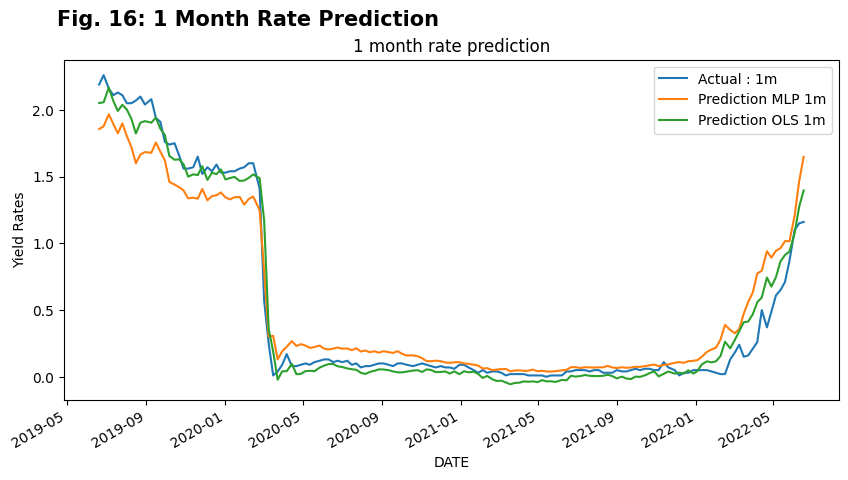

In [ ]:
pd.DataFrame(
    {
        "Actual : 1m": y_test.loc[:, "1m_pred"],
        "Prediction MLP 1m": Y_predMLP.loc[:, "1m_pred"],
        "Prediction OLS 1m": Y_predOLS.loc[:, "1m_pred"],
    }
).plot(figsize=(10, 5))
pyplot.title("1 month rate prediction")
pyplot.ylabel("Yield Rates")
pyplot.suptitle(
    "Fig. 16: 1 Month Rate Prediction",
    fontweight="bold",
    horizontalalignment="right",
    fontsize=15,
)
pyplot.show